In [5]:
!pip install matplotlib --upgrade
!pip install Pillow --upgrade

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/3c/a5/54a497ca4af8e76adfe7c5a1712f3bb6b2222d464fe736b60aaafd425945/matplotlib-3.9.1-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/8.0 MB 1.7 MB/s eta 0:00:05
   - -------------------------------------- 0.2/8.0 MB 2.1 MB/s eta 0:00:04
   - -------------------------------------- 0.4/8.0 MB 2.9 MB/s eta 0:00:03
   -- ------------------------------------- 0.6/8.0 MB 3.3 MB/s eta 0:00:03
   --- ------------------------------------ 0.8/8.0 MB 4.1 MB/s eta 0:00:02
   ----- ---------------------------------- 1.1/8.0 MB 4.6 MB/s eta 0:00:02
   ------- -------------------------------- 1.5/8.0 MB 5.6 MB/s eta 0:00:02
   --------- ------------------------------ 1.9/8.0 MB 6.1 MB/s eta 0:00:01
   ----------- -------------------------

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow import keras

In [30]:
data_dir = 'dataset/kvasirv2/train'

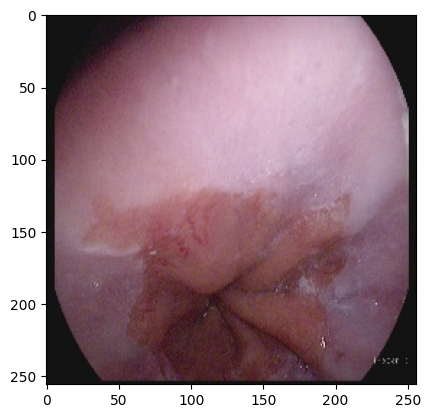

In [27]:
import cv2

test = cv2.imread('dataset/kvasirv2/training_data/esophagitis/00fb1871-41c0-4619-be56-29690d145b1d.jpg')
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(test)

In [28]:
test.shape

(256, 256, 3)

In [31]:
from tensorflow.keras.utils import image_dataset_from_directory
image_height = 256
image_width = 256
batch_size = 32
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 3,
    image_size = (image_height, image_width),
    batch_size = batch_size)

Found 6400 files belonging to 8 classes.
Using 5120 files for training.


In [32]:
class_names = train_ds.class_names
len(class_names)

8

In [33]:
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [37]:
validation_ds = image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 3,
    image_size = (image_height, image_width),
    batch_size = batch_size)

Found 6400 files belonging to 8 classes.
Using 1280 files for validation.


In [39]:
from keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, Activation

polypnet_model = Sequential()
pretrained_model = ResNet50(include_top = False, input_shape = (256,256,3), pooling = 'avg', classes = 8, weights = 'imagenet')
for layer in pretrained_model.layers:
    layer.trainable = False

polypnet_model.add(pretrained_model)
polypnet_model.add(Flatten())
polypnet_model.add(Dense(512, activation = 'relu'))
polypnet_model.add(Dense(8, activation = 'softmax'))

In [40]:
from keras.optimizers import Adam
polypnet_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [41]:
polypnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24640904 (94.00 MB)
Trainable params: 1053192 (4.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [42]:
epochs = 10
history = polypnet_model.fit(train_ds, validation_data = validation_ds, epochs = epochs)

Epoch 1/10
160/160 [==============================] - 220s 1s/step - loss: 0.7224 - accuracy: 0.7396 - val_loss: 0.4304 - val_accuracy: 0.8336
Epoch 2/10
160/160 [==============================] - 230s 1s/step - loss: 0.3665 - accuracy: 0.8590 - val_loss: 0.3322 - val_accuracy: 0.8687
Epoch 3/10
160/160 [==============================] - 231s 1s/step - loss: 0.3029 - accuracy: 0.8818 - val_loss: 0.3113 - val_accuracy: 0.8805
Epoch 4/10
160/160 [==============================] - 235s 1s/step - loss: 0.2646 - accuracy: 0.8984 - val_loss: 0.2987 - val_accuracy: 0.8914
Epoch 5/10
160/160 [==============================] - 235s 1s/step - loss: 0.2312 - accuracy: 0.9148 - val_loss: 0.2968 - val_accuracy: 0.8781
Epoch 6/10
160/160 [==============================] - 235s 1s/step - loss: 0.2087 - accuracy: 0.9252 - val_loss: 0.2803 - val_accuracy: 0.8906
Epoch 7/10
160/160 [==============================] - 237s 1s/step - loss: 0.1996 - accuracy: 0.9277 - val_loss: 0.2894 - val_accuracy: 0.8813

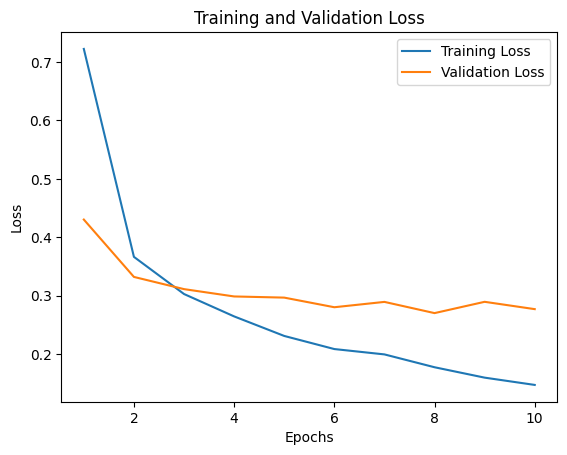

In [43]:
t_loss = history.history['loss']
v_loss = history.history['val_loss']
t_acc = history.history['accuracy']
v_acc = history.history['val_accuracy']

epochs_range = range(1, len(t_loss) + 1)

plt.plot(epochs_range,t_loss, label = 'Training Loss')
plt.plot(epochs_range, v_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

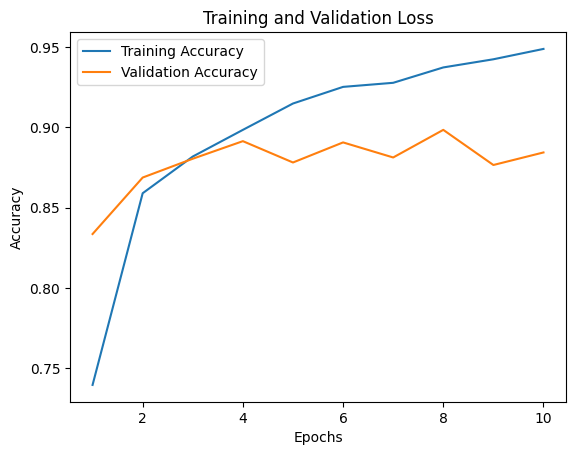

In [44]:
t_loss = history.history['loss']
v_loss = history.history['val_loss']
t_acc = history.history['accuracy']
v_acc = history.history['val_accuracy']

epochs_range = range(1, len(t_loss) + 1)

plt.plot(epochs_range,t_acc, label = 'Training Accuracy')
plt.plot(epochs_range, v_acc, label = 'Validation Accuracy')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [45]:
polypnet_model.save('polypnet_model.h5')

C:\Users\91923\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 847ms/step
esophagitis


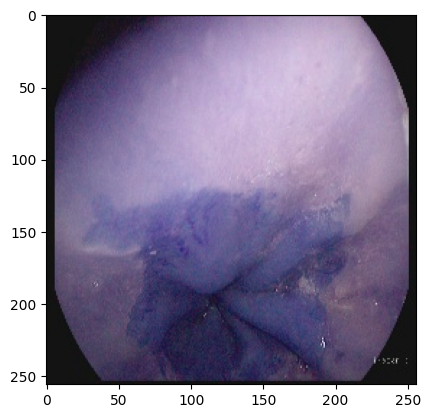

In [46]:
test_path = 'dataset/kvasirv2/training_data/esophagitis/00fb1871-41c0-4619-be56-29690d145b1d.jpg'
test_image = cv2.imread(test_path)
plt.imshow(test_image)
image_resized = cv2.resize(test_image, (256, 256))
test_image = np.expand_dims(image_resized, axis=0)
predictions = polypnet_model.predict(test_image)
output = class_names[np.argmax(predictions)]
print(output)

In [47]:
def test(path):
    test_path = path
    test_image = cv2.imread(test_path)
    plt.imshow(test_image)
    image_resized = cv2.resize(test_image, (256, 256))
    test_image = np.expand_dims(image_resized, axis=0)
    predictions = polypnet_model.predict(test_image)
    output = class_names[np.argmax(predictions)]
    print(output)


1/1 [==============================] - 0s 76ms/step
dyed-lifted-polyps


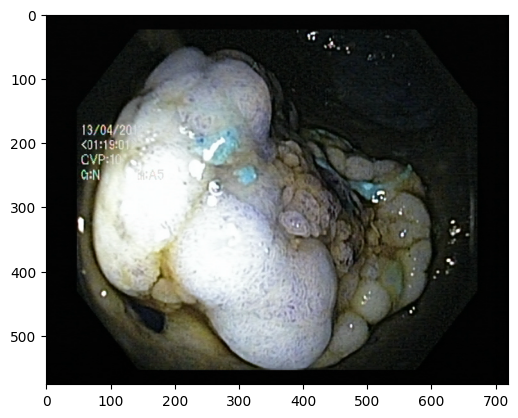

In [48]:
test('dataset/kvasirv2/train/dyed-lifted-polyps/00cf9508-6ad1-4db9-840a-519c1d515c30.jpg')

In [49]:
!pip install pyqt5

In [ ]:
import sys
import os
from PyQt5.QtWidgets import QApplication, QMainWindow, QWidget, QVBoxLayout, QLabel, QPushButton, QFileDialog, QTabWidget, QListWidget, QListWidgetItem, QHBoxLayout
from PyQt5.QtGui import QPixmap, QImage
from PyQt5.QtCore import Qt
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

class ImageClassifierApp(QMainWindow):
    def __init__(self):
        super().__init__()

        self.setWindowTitle("Image Classifier")
        self.setGeometry(100, 100, 800, 600)

        self.class_names = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']  # Replace with your actual class names

        self.model = load_model('polypnet_model.h5')

        self.initUI()

    def initUI(self):
        self.tabs = QTabWidget()
        self.setCentralWidget(self.tabs)

        self.classify_tab = QWidget()
        self.history_tab = QWidget()

        self.tabs.addTab(self.classify_tab, "Classify")
        self.tabs.addTab(self.history_tab, "History")

        self.initClassifyTab()
        self.initHistoryTab()

    def initClassifyTab(self):
        layout = QVBoxLayout()

        self.image_label = QLabel("No image selected")
        self.image_label.setAlignment(Qt.AlignCenter)
        layout.addWidget(self.image_label)

        self.result_label = QLabel("")
        self.result_label.setAlignment(Qt.AlignCenter)
        layout.addWidget(self.result_label)

        self.select_button = QPushButton("Select Image")
        self.select_button.clicked.connect(self.openImage)
        layout.addWidget(self.select_button)

        self.classify_tab.setLayout(layout)

    def initHistoryTab(self):
        layout = QVBoxLayout()

        self.history_list = QListWidget()
        layout.addWidget(self.history_list)

        self.history_tab.setLayout(layout)

    def openImage(self):
        options = QFileDialog.Options()
        file_name, _ = QFileDialog.getOpenFileName(self, "Select Image", "", "Images (*.png *.xpm *.jpg *.bmp *.gif);;All Files (*)", options=options)
        if file_name:
            self.displayImage(file_name)
            self.classifyImage(file_name)

    def displayImage(self, file_path):
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, ch = image.shape
        bytes_per_line = ch * w
        convert_to_qt_format = QImage(image.data, w, h, bytes_per_line, QImage.Format_RGB888)
        pixmap = QPixmap.fromImage(convert_to_qt_format)
        self.image_label.setPixmap(pixmap.scaled(self.image_label.size(), Qt.KeepAspectRatio))

    def classifyImage(self, file_path):
        test_image = cv2.imread(file_path)
        image_resized = cv2.resize(test_image, (256, 256))
        test_image = np.expand_dims(image_resized, axis=0)

        predictions = self.model.predict(test_image)
        output_class = self.class_names[np.argmax(predictions)]

        self.result_label.setText(f"Class: {output_class}, Confidence: {np.max(predictions):.2f}")

        self.addToHistory(file_path, output_class, np.max(predictions))

    def addToHistory(self, file_path, output_class, confidence):
        history_item_widget = QWidget()
        layout = QHBoxLayout()

        image_label = QLabel()
        pixmap = QPixmap(file_path)
        image_label.setPixmap(pixmap.scaled(100, 100, Qt.KeepAspectRatio))
        layout.addWidget(image_label)

        text_label = QLabel(f"Class: {output_class}, Confidence: {confidence:.2f}")
        layout.addWidget(text_label)

        history_item_widget.setLayout(layout)
        list_item = QListWidgetItem()
        list_item.setSizeHint(history_item_widget.sizeHint())

        self.history_list.addItem(list_item)
        self.history_list.setItemWidget(list_item, history_item_widget)

if __name__ == "__main__":
    app = QApplication(sys.argv)
    window = ImageClassifierApp()
    window.show()
    sys.exit(app.exec_())


1/1 [==============================] - 0s 70ms/step
